In [1]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px
import plotly
import datetime as dt
import seaborn as sns

In [2]:
import geopy
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
from shapely.geometry import Point, Polygon
import folium

In [3]:
import numpy as np
import pandas as pd
import urllib.request
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import re
import googlemaps
import requests
import json
import csv
from zipfile import ZipFile
import urllib.request

In [8]:
#import geojson
#import geopandas as gpd
#from geojson import Polygon

In [9]:
# Custom function to retrieve some CKAN datasets from city of Toronto

def retrieve_CKAN_dataset(base_url, package, dataset_number):
    
    package_information_url= base_url + package
    print(package_information_url)
   # Make the HTTP request
    package_information = requests.get(package_information_url)

    # Use the json module to load CKAN's response into a dictionary
    package_dict = json.loads(package_information.content)

    # Check the contents of the response.
    assert package_dict['success'] is True  # again make sure if response is OK
    package_dict = package_dict['result']   # we only need the 'result' part from the dictionary

    # pprint.pprint(package_dict)           # pretty print the package information to screen
    
    # Get the url for the data from the dictionary
    data_url = package_dict['resources'][dataset_number]['url']
    print('Data url:     ' + data_url)

    # Print the data format
    data_format = package_dict['resources'][dataset_number]['format']
    print('Data format:  ' + data_format)
    
    # List of formats we work with in this exercise
    csv = ['comma-separated-values', 'CSV', 'csv', 'txt', 'TXT']
    tsv = ['tab-separated-values', 'TSV', 'tsv']
    xls = ['XLS']
    Zip = ['ZIP', 'zip']
    Json= ['JSON']

    # Download the data to a Pandas DataFrame. Use seperate function calls, depending on the format of the dataset.
    if any(s in data_format for s in csv):     # pd.read_csv()
        df = pd.read_csv(data_url)
    elif any(s in data_format for s in tsv):   # pd.read_csv() and specify the delimiter
        df = pd.read_csv(data_url, sep='\t')
    elif any(s in data_format for s in xls):   # pd.read_excel()
        df = pd.read_excel(data_url)
    elif any(s in data_format for s in Json):   # pd.read_json()
        with urllib.request.urlopen(data_url) as url:
            data = json.loads(url.read().decode())
            df = pd.DataFrame(json_normalize(data, 'carparks'))

    elif any(s in data_format for s in Zip):     # pd.read_csv()
        df = pd.concat([pd.read_csv(ZipFile(data_url).open(i)) for i in ZipFile(data_url).namelist()],    ignore_index=True)
    else:
        print('Sorry, the data format is not supported for this exercise')

    # Print the first rows to the screen to inspect the dataset    
    return df

In [10]:
# Fownload Green P Parking, and sociodemographic datasets
df_Parking_2019=retrieve_CKAN_dataset('https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show?', 'id=b66466c3-69c8-4825-9c8b-04b270069193', 0)
df_education_indicators=retrieve_CKAN_dataset('https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show?', 'id=9ef4b82b-bd63-4c6b-b87b-7bd04f2a2fd3', 0)
df_Demographic_indicator=retrieve_CKAN_dataset('https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show?', 'id=9ef4b82b-bd63-4c6b-b87b-7bd04f2a2fd3', 1)

https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show?id=b66466c3-69c8-4825-9c8b-04b270069193
Data url:     https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/b66466c3-69c8-4825-9c8b-04b270069193/resource/8549d588-30b0-482e-b872-b21beefdda22/download/green-p-parking-2019.json
Data format:  JSON


<ipython-input-9-2c01f3a6f1d7>:44: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  df = pd.DataFrame(json_normalize(data, 'carparks'))


https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show?id=9ef4b82b-bd63-4c6b-b87b-7bd04f2a2fd3
Data url:     https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/9ef4b82b-bd63-4c6b-b87b-7bd04f2a2fd3/resource/82b7a237-e96e-4983-8be9-66ca62ea6fad/download/education-nhs-indicators-2011.xlsx
Data format:  XLSX
https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show?id=9ef4b82b-bd63-4c6b-b87b-7bd04f2a2fd3
Data url:     https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/9ef4b82b-bd63-4c6b-b87b-7bd04f2a2fd3/resource/af7af623-883f-418a-8d23-881ff9b32f94/download/demographics-nhs-indicators-2011.xlsx
Data format:  XLSX


In [11]:
# Feature Engineering: Extract the Neighborhood ID from the Geography Column in order to be able to join the table with the Demographics table

df_education_indicators['ID']=df_education_indicators.Geography
pattern= r'(\(\d+\)(?!\%))'
df_education_indicators.ID.apply(lambda x: re.findall(pattern, x)[0][1:-1])

0      129
1      128
2       20
3       95
4       42
      ... 
135     94
136    100
137     97
138     27
139     31
Name: ID, Length: 140, dtype: object

In [12]:
df_education_indicators.ID=df_education_indicators.ID.apply(lambda x: re.findall(pattern, x)[0][1:-1])

In [13]:
df_education_indicators

,Geography,"Total population aged 15 years and over by highest certificate, diploma or degree","No certificate, diploma or degree",High school diploma or equivalent,"Postsecondary certificate, diploma or degree",Apprenticeship or trades certificate or diploma,"College, CEGEP or other non-university certificate or diploma",University certificate or diploma below bachelor level,"University certificate, diploma or degree at bachelor level or above",Bachelor's degree,"University certificate, diploma or degree above bachelor level",Unnamed: 11,Unnamed: 12,ID
0,TOR - HOOD - Agincourt North (129) ( 23.7%),25765,5965,7480,12320,1015,3465,1805,6030,4350,1680,NaN,HIERARCHY,129
1,TOR - HOOD - Agincourt South-Malvern West (128...,18595,4065,4840,9695,900,2730,1150,4920,3230,1690,NaN,Total population aged 15 years and over by hig...,128
2,TOR - HOOD - Alderwood (20) ( 25.4%),10210,2290,2560,5360,800,2090,455,2015,1390,625,NaN,"No certificate, diploma or degree",20
3,TOR - HOOD - Annex (95) ( 27.9%),25185,1685,4275,19225,665,2580,1125,14855,7655,7195,NaN,High school diploma or equivalent,95
4,TOR - HOOD - Banbury-Don Mills (42) ( 23.6%),22855,2300,4715,15840,1170,3385,1400,9885,5665,4220,NaN,"Postsecondary certificate, diploma or degree",42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,TOR - HOOD - Wychwood (94) ( 22.3%),10865,1970,2230,6665,630,1410,445,4175,2570,1605,NaN,NaN,94
136,TOR - HOOD - Yonge-Eglinton (100) ( 20.1%),9015,490,1470,7045,290,1245,350,5155,2875,2275,NaN,NaN,100
137,TOR - HOOD - Yonge-St.Clair (97) ( 21.0%),10575,340,1255,8975,260,1435,435,6835,3920,2920,NaN,NaN,97
138,TOR - HOOD - York University Heights (27) ( 27...,22875,5490,6620,10770,1175,3425,1140,5025,3225,1805,NaN,NaN,27


In [14]:
#Drop first row as it contains label codes 
df_Demographic_indicator.drop([0],inplace=True)

In [15]:
df_Demographic_indicator.rename(columns={'Hood#':'ID'}, inplace=True)
df_Demographic_indicator.ID=df_Demographic_indicator.ID.astype('int32')
df_education_indicators.ID=df_education_indicators.ID.astype('int32')
df_edu_demo_merged=df_education_indicators.merge(df_Demographic_indicator, on='ID')

In [16]:
df_edu_demo_merged

,Geography,"Total population aged 15 years and over by highest certificate, diploma or degree","No certificate, diploma or degree_x",High school diploma or equivalent,"Postsecondary certificate, diploma or degree",Apprenticeship or trades certificate or diploma,"College, CEGEP or other non-university certificate or diploma_x",University certificate or diploma below bachelor level_x,"University certificate, diploma or degree at bachelor level or above",Bachelor's degree,...,Total number of private households by tenure,Owner,Renter,% of owner households spending 30% or more of household total income on shelter costs,Major repairs needed,Average monthly shelter costs for rented dwellings ($),Average after-tax family income $ (Family income in 2010 of economic families),Household income in 2010 of private households,Median household total income $,Median after-tax household income $
0,TOR - HOOD - Agincourt North (129) ( 23.7%),25765,5965,7480,12320,1015,3465,1805,6030,4350,...,9145,7335,1810,32,425,976,67622,9145,60162,55893
1,TOR - HOOD - Agincourt South-Malvern West (128...,18595,4065,4840,9695,900,2730,1150,4920,3230,...,6885,5250,1635,32.3,590,971,68465,6885,59013,53886
2,TOR - HOOD - Alderwood (20) ( 25.4%),10210,2290,2560,5360,800,2090,455,2015,1390,...,4665,3635,1030,18.2,375,984,83584,4660,71585,61402
3,TOR - HOOD - Annex (95) ( 27.9%),25185,1685,4275,19225,665,2580,1125,14855,7655,...,15550,5770,9780,29.3,1110,1237,141111,15545,57825,49912
4,TOR - HOOD - Banbury-Don Mills (42) ( 23.6%),22855,2300,4715,15840,1170,3385,1400,9885,5665,...,11770,7035,4735,25.8,570,1213,115239,11770,70039,60203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,TOR - HOOD - Wychwood (94) ( 22.3%),10865,1970,2230,6665,630,1410,445,4175,2570,...,5530,2700,2830,21.4,645,930,90496,5530,55941,50261
136,TOR - HOOD - Yonge-Eglinton (100) ( 20.1%),9015,490,1470,7045,290,1245,350,5155,2875,...,5205,2050,3155,16.6,390,1246,140907,5200,72977,63267
137,TOR - HOOD - Yonge-St.Clair (97) ( 21.0%),10575,340,1255,8975,260,1435,435,6835,3920,...,6780,2625,4160,18.7,515,1314,173751,6780,71728,58838
138,TOR - HOOD - York University Heights (27) ( 27...,22875,5490,6620,10770,1175,3425,1140,5025,3225,...,10315,4650,5660,33.3,810,911,59770,10310,45534,42916


In [17]:
# Parking Infraction tables needed direct download and importation into panda dataframes: 
# With more than 31M records, the couple of dozen of discarded rows won't impact our analysis
df_Parking_Tickets_2008=pd.read_csv("parking-tickets-2008.zip", error_bad_lines=False,  encoding='utf-16')
df_Parking_Tickets_2009=pd.read_csv("parking-tickets-2009.zip", error_bad_lines=False)
df_Parking_Tickets_2010=pd.read_csv("parking-tickets-2010.zip", error_bad_lines=False,  encoding='utf-16')
df_Parking_Tickets_2011=pd.read_csv("parking-tickets-2011.zip", error_bad_lines=False)
df_Parking_Tickets_2012=pd.read_csv("parking-tickets-2012.zip", error_bad_lines=False)
df_Parking_Tickets_2013=pd.read_csv("parking-tickets-2013.zip", error_bad_lines=False, quoting=csv.QUOTE_NONE)
df_Parking_Tickets_2014=pd.concat([pd.read_csv(ZipFile('parking-tickets-2014.zip').open(i)) for i in ZipFile('parking-tickets-2014.zip').namelist()],    ignore_index=True)
df_Parking_Tickets_2015=pd.concat([pd.read_csv(ZipFile('parking-tickets-2015.zip').open(i)) for i in ZipFile('parking-tickets-2015.zip').namelist()],    ignore_index=True)
df_Parking_Tickets_2016=pd.concat([pd.read_csv(ZipFile('parking-tickets-2016.zip').open(i)) for i in ZipFile('parking-tickets-2016.zip').namelist()],    ignore_index=True)
df_Parking_Tickets_2017=pd.concat([pd.read_csv(ZipFile('parking-tickets-2017.zip').open(i)) for i in ZipFile('parking-tickets-2017.zip').namelist()],    ignore_index=True)
df_Parking_Tickets_2018=pd.concat([pd.read_csv(ZipFile('parking-tickets-2018.zip').open(i)) for i in ZipFile('parking-tickets-2018.zip').namelist()],    ignore_index=True)
df_Parking_Tickets_2019=pd.concat([pd.read_csv(ZipFile('parking_tags_data_2019.zip').open(i)) for i in ZipFile('parking_tags_data_2019.zip').namelist()],    ignore_index=True)
df_Parking_Tickets_2020=pd.concat([pd.read_csv(ZipFile('parking_tags_data_2020.zip').open(i)) for i in ZipFile('parking_tags_data_2020.zip').namelist()],    ignore_index=True)

b'Skipping line 181770: expected 11 fields, saw 12\n'


Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\amg_m\Anaconda3

  added / updated specs:
    - geojson


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geojson-2.5.0              |             py_0          15 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          15 KB

The following NEW packages will be INSTALLED:

  geojson            conda-forge/noarch::geojson-2.5.0-py_0




geojson-2.5.0        | 15 KB     |            |   0% 
geojson-2.5.0        | 15 KB     | ########## | 100% 
geojson-2.5.0        | 15 KB     | ########## | 100% 
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


b'Skipping line 170864: expected 11 fields, saw 12\n'
b'Skipping line 1075521: expected 11 fields, saw 14\n'
b'Skipping line 1413505: expected 11 fields, saw 16\n'
b'Skipping line 15741: expected 11 fields, saw 14\n'
b'Skipping line 120129: expected 11 fields, saw 12\n'
b'Skipping line 178600: expected 11 fields, saw 12\n'
b'Skipping line 265260: expected 11 fields, saw 12\n'
b'Skipping line 448877: expected 11 fields, saw 12\n'
b'Skipping line 481658: expected 11 fields, saw 12\n'
b'Skipping line 582687: expected 11 fields, saw 13\n'
b'Skipping line 678495: expected 11 fields, saw 12\n'
b'Skipping line 787166: expected 11 fields, saw 12\n'
b'Skipping line 925038: expected 11 fields, saw 12\n'
b'Skipping line 1341891: expected 11 fields, saw 12\n'
b'Skipping line 1574918: expected 11 fields, saw 12\n'
b'Skipping line 1648058: expected 11 fields, saw 12\nSkipping line 1675730: expected 11 fields, saw 13\n'
b'Skipping line 1766723: expected 11 fields, saw 12\n'
b'Skipping line 2129390: e

In [18]:
# Prior to concatinating the tables, we check that their columns match

In [19]:
df_Parking_Tickets_2008.columns

Index(['tag_number_masked', 'date_of_infraction', 'infraction_code',
       'infraction_description', 'set_fine_amount', 'time_of_infraction',
       'location1', 'location2', 'location3', 'location4', 'province'],
      dtype='object')

In [20]:
df_Parking_Tickets_2015.columns

Index(['tag_number_masked', 'date_of_infraction', 'infraction_code',
       'infraction_description', 'set_fine_amount', 'time_of_infraction',
       'location1', 'location2', 'location3', 'location4', 'province'],
      dtype='object')

In [21]:
df_Parking_Tickets_2019.columns

Index(['tag_number_masked', 'date_of_infraction', 'infraction_code',
       'infraction_description', 'set_fine_amount', 'time_of_infraction',
       'location1', 'location2', 'location3', 'location4', 'province'],
      dtype='object')

In [22]:
df_Parking_Tickets=pd.concat([df_Parking_Tickets_2008, df_Parking_Tickets_2009, df_Parking_Tickets_2010, df_Parking_Tickets_2011, df_Parking_Tickets_2012, 
          df_Parking_Tickets_2013, df_Parking_Tickets_2014, df_Parking_Tickets_2015, df_Parking_Tickets_2016, df_Parking_Tickets_2017, df_Parking_Tickets_2018,
          df_Parking_Tickets_2019,df_Parking_Tickets_2020])

df_Parking_Tickets.reset_index(drop=True, inplace=True)

In [23]:
df_Parking_Tickets.columns

Index(['tag_number_masked', 'date_of_infraction', 'infraction_code',
       'infraction_description', 'set_fine_amount', 'time_of_infraction',
       'location1', 'location2', 'location3', 'location4', 'province'],
      dtype='object')

In [24]:
df_Parking_Tickets.isnull().any()

tag_number_masked         False
date_of_infraction        False
infraction_code            True
infraction_description    False
set_fine_amount           False
time_of_infraction         True
location1                  True
location2                  True
location3                  True
location4                  True
province                   True
dtype: bool

In [25]:
## Two records missing infraction code. Although these records won't skew the data, its quite easy to replace them by looking up similar infraction description in the dataset.
## We will perform a lookup of the infraction descriptions with the missing codes below.

In [26]:
df_Parking_Tickets[df_Parking_Tickets.infraction_code.isnull()]

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
21864443,***38875,20160916,NaN,PARK ON PRIVATE PROPERTY,30,1042.0,NaN,2075 BAYVIEW AVE,NaN,NaN,ON
24727605,***56038,20170901,NaN,PARK IN ACCESSIBLE NO PERMIT,450,1140.0,NaN,941 PROGRESS AVE,NaN,NaN,ON


In [27]:
df_Parking_Tickets[df_Parking_Tickets.infraction_description.str.contains('PARK ON PRIVATE PROPERTY') ].head(1)

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
17555258,***14438,20141015,3.0,PARK ON PRIVATE PROPERTY,30,2.0,NaN,539 QUEENS QUAY WEST,NaN,NaN,ON


In [28]:
df_Parking_Tickets[df_Parking_Tickets.infraction_description.str.contains('PARK IN ACCESSIBLE NO PERMIT') ].head(1)

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
14192960,***01252,20130313,355.0,PARK IN ACCESSIBLE NO PERMIT,450,132.0,AT,801 DIXON RD,NaN,NaN,ON


In [29]:
# We update the missing infraction code with the corresponding values
df_Parking_Tickets.loc[21864443, 'infraction_code']=3
df_Parking_Tickets.loc[24727605, 'infraction_code']=355

In [30]:
len(df_Parking_Tickets)

31045755

In [31]:
#1.	What are the top 20 ticket infractions (frequency)

df_Parking_Tickets.groupby(by='infraction_description').size().reset_index(name='Count').sort_values(by='Count', ascending=False).head(20)

,infraction_description,Count
243,PARK PROHIBITED TIME NO PERMIT,4748990
126,PARK FAIL TO DISPLAY RECEIPT,2792616
379,PARK-SIGNED HWY-PROHIBIT DY/TM,2457461
219,PARK ON PRIVATE PROPERTY,2313389
160,PARK HWY PROHIBED TIME/DAY,2242624
393,PARK/LEAVE ON PRIVATE PROPERTY,2207580
124,PARK FAIL TO DEP. FEE MACHINE,1561352
187,PARK MACHINE-REQD FEE NOT PAID,1191898
583,STOP-SIGNED HWY-PROHIBIT TM/DY,701965
511,STOP HWY PROHIBITED TIME/DAY,623460


In [32]:
#2. What are the top 20 ticket infractions (revenue)

df_top_rev_tickets=df_Parking_Tickets.groupby(by='infraction_description').agg({'set_fine_amount':'sum'}).sort_values(by='set_fine_amount', ascending=False).reset_index().head(20)
df_top_rev_tickets.rename(columns={'set_fine_amount':'Total Revenue'}, inplace=True)

In [33]:
df_top_rev_tickets

,infraction_description,Total Revenue
0,PARK PROHIBITED TIME NO PERMIT,142469700
1,PARK-SIGNED HWY-PROHIBIT DY/TM,113983570
2,PARK HWY PROHIBED TIME/DAY,87466430
3,PARK FAIL TO DISPLAY RECEIPT,83778450
4,PARK ON PRIVATE PROPERTY,69401670
5,PARK/LEAVE ON PRIVATE PROPERTY,66227400
6,STOP-SIGNED HIGHWAY-RUSH HOUR,65424450
7,PARK IN A FIRE ROUTE,63841000
8,PARK FAIL TO DEP. FEE MACHINE,46840560
9,STOP-SIGNED HWY-PROHIBIT TM/DY,46342660


#### We note that highest revenue was generated by 'Park Prohibited Time No permit' and 'Park-Signed HWY-Prohibitied DY/TM' infraction desciptions.

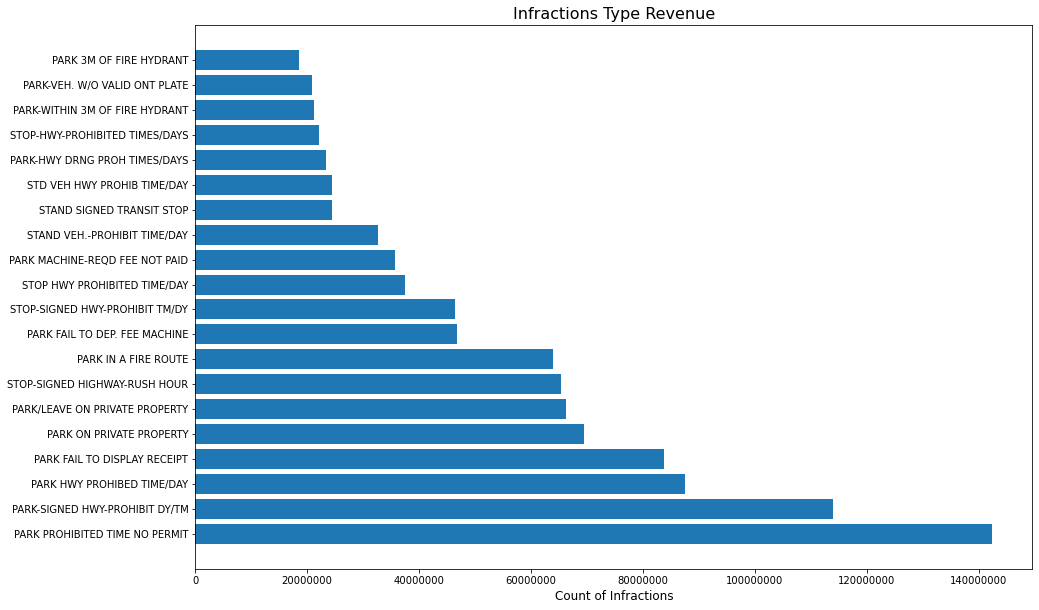

In [34]:
fig, ax=plt.subplots(figsize=(15,10))
plt.title('Infractions Type Revenue',  fontsize=16)
plt.ticklabel_format(style='plain') 
plt.barh(df_top_rev_tickets['infraction_description'], df_top_rev_tickets['Total Revenue'])
plt.xlabel('Count of Infractions',  fontsize=12)
plt.show()

In [35]:
#3.	What are the socio-demographic trends that are of note in the areas of infractions
# We extract top 20 locations of traffic infractions.
# We note that 2075 Bayview Ave + 2075 Bayview AV has two different records and should be combined. Thus we took top 21 locations to account for that
df_Top_20_infraction_Locations=df_Parking_Tickets.groupby(by='location2').size().reset_index(name='Count').sort_values(by='Count', ascending=False).head(21)
df_Top_20_infraction_Locations.reset_index(drop=True, inplace=True)

In [36]:
df_Top_20_infraction_Locations

,location2,Count
0,2075 BAYVIEW AVE,74067
1,20 EDWARD ST,68836
2,1750 FINCH AVE E,52805
3,JAMES ST,38110
4,2075 BAYVIEW AV,36430
5,25 ST MARY ST,26094
6,40 ORCHARD VIEW BLVD,25890
7,LA PLANTE AVE,25851
8,2 COOPER ST,24965
9,1 BRIMLEY RD S,24961


In [37]:
df_Top_20_infraction_Locations.to_csv('df_Top_20_infraction_Locations.csv')

By looking up associated addresses and neighborhoods in the educational and demographic dataset, we note the following:

1- Top infraction location, 2075 Finch Ave with a total of more 110'000 infractions in the dataset, its in Bridle Path - Sunnybrook- York Mills neighborhood and the address is the Sunnybrooks Hospital. According to the dataset, the total population of that area is 8715. the median household total pretax income of that population is $208'674. On average, $2388 are spent on cost for rented dwelling. 4295 (49%)  persons have a university degree 7195 (81%) people have a a higher diploma or degree. 630 had no degrees. 22% of the population identify as a visible minority. Nontheless its important to note that the socio-demographic trends of the area are not relevant to the study as the address belongs to a major hospital that serves a much wider population of the City of Toronto

2- Other top infraction locations include areas around Seneca College, UHN Toronto Hospital, Wine stores, Scarborough Bluffs, The West Mall, Yorkdale Mall, and Curtis Park. Hence, once again, these frequent- infraction areas serve public attractions / hospitals that serve a far wider catchment area than the immeadiate neighborhood. Therefore, it will be irrelevant to analyze the socio-demographic trends of that given area.

3- One exception to the first two points are two addresses near large condo blocks at 20 Edwards St and 25 St Mary St. According to the dataset, the total population of that area is 28345. the median household total pretax income of that population is $47'195. On average, $1134 are spent on cost for rented dwelling. 1250 (4%)  persons have a university degree 7195 (71%) people have a a higher diploma or degree. 1520 (5%) had no degrees. 37% of the population identify as a visible minority. This area has a significantly lower number of population with a University Degree compared to point 1. 

In [445]:
#4.	Total revenue generated from all tickets: $1'362'716'985

df_Parking_Tickets.set_fine_amount.sum()

1362716985

In [446]:
# We Geo-code the location address to retrieve the neighborhood

df_Top_20_infraction_Locations['LON']=0.00
df_Top_20_infraction_Locations['LAT']=0.00

geolocator = Nominatim(user_agent="MapQuest")

for i in range(len(df_Top_20_infraction_Locations)):
    try:
        location = geolocator.geocode(df_Top_20_infraction_Locations.iloc[i].location2+' '+'Toronto')
        df_Top_20_infraction_Locations.at[i, 'LON']=location.longitude
        df_Top_20_infraction_Locations.at[i, 'LAT']=location.latitude
        #print((location.latitude,location.longitude))
    except:
        continue

In [ ]:
gdf_City_Wards=gpd.read_file('City Wards Data.geojson') # Geojson file imported to use in spatial mapping in addition to determining the ward for each infraction
gs1=gpd.GeoSeries(gdf_City_Wards.geometry)

In [ ]:
# This function looks up the ward using GPS coordinates point checked against being in a polygon

def lookup_ward(coordinates):
  try:
    coordinates=Point(coordinates)
    gs=gpd.GeoSeries(gdf_City_Wards.geometry)
    result=gs1.contains(coordinates)
    idx=result[result==True].index[0]
    area_name= gdf_City_Wards.iloc[idx].AREA_NAME
  except:
    return "Not in Toronto"
  return area_name

In [ ]:
# We use the above function to look-up ward data with the help of Geopandas library
gdf_City_Wards=gpd.read_file('City Wards Data.geojson') # Geojson file imported to use in spatial mapping in addition to determining the ward for each infraction

df_Top_20_infraction.WARD= df_Top_20_infraction.WARD.astype('str') # We convert the data type to string prior to writing the Ward data
for i in range(len(df_Top_20_infraction)): 
  df_Top_20_infraction.at[i,'WARD']=lookup_ward((df_Top_20_infraction.iloc[i].LON, df_Top_20_infraction.iloc[i].LAT))

In [479]:
df_Top_20_infraction_Locations=pd.read_csv('temp_with_wards.csv', index_col=[0]) # File processed in Google Colab with Geopandas to determine Ward using polygon calc method

In [481]:
# We rename the Ward Name to AREA_NAME to match the key in the geojson file for proper geospatial mapping
df_Top_20_infraction_Locations.rename(columns={'WARD':'AREA_NAME'}, inplace=True)

In [482]:
df_Top_20_infraction_Locations

,Unnamed: 0.1,location2,Count,LON,LAT,AREA_NAME
0,0,2075 BAYVIEW AVE,74067,-79.376572,43.721690,Don Valley West
1,1,20 EDWARD ST,68836,-79.382067,43.656941,University-Rosedale
2,2,1750 FINCH AVE E,52805,-79.350308,43.793791,Don Valley North
3,3,JAMES ST,38110,-79.381195,43.653344,Toronto Centre
4,4,2075 BAYVIEW AV,36430,-79.376572,43.721690,Don Valley West
5,5,25 ST MARY ST,26094,-79.387191,43.667332,Toronto Centre
6,6,40 ORCHARD VIEW BLVD,25890,-79.400068,43.708380,Eglinton-Lawrence
7,7,LA PLANTE AVE,25851,-79.386023,43.659193,University-Rosedale
8,8,2 COOPER ST,24965,-79.372588,43.642989,Spadina-Fort York
9,9,1 BRIMLEY RD S,24961,-79.235492,43.705962,Scarborough Southwest


#### Infraction distribution (Count)

In [486]:
# Geographic distribution of infractions by count

geo_file="City Wards Data.geojson"
m=folium.Map(location=[43.64025821921681,-79.4763369753134], zoom_start=10)
#bins = list(df_infraction_by_ward_grouped["Count"].quantile([0, 0.25, 0.35, 0.5, 0.75, 0.85, 1]))

for i in range(len(df_Top_20_infraction_Locations)):
  
  folium.Marker(
      location=[df_Top_20_infraction_Locations.iloc[i].LAT, df_Top_20_infraction_Locations.iloc[i].LON],
      popup='Location:'+df_Top_20_infraction_Locations.iloc[i].location2+' Infractions: '+str(df_Top_20_infraction_Locations.iloc[i].Count),
      icon=folium.Icon(icon="star"),
  ).add_to(m)


m


In [494]:
df_Top_20_infraction_Locations

,Unnamed: 0.1,location2,Count,LON,LAT,AREA_NAME
0,0,2075 BAYVIEW AVE,74067,-79.376572,43.721690,Don Valley West
1,1,20 EDWARD ST,68836,-79.382067,43.656941,University-Rosedale
2,2,1750 FINCH AVE E,52805,-79.350308,43.793791,Don Valley North
3,3,JAMES ST,38110,-79.381195,43.653344,Toronto Centre
4,4,2075 BAYVIEW AV,36430,-79.376572,43.721690,Don Valley West
5,5,25 ST MARY ST,26094,-79.387191,43.667332,Toronto Centre
6,6,40 ORCHARD VIEW BLVD,25890,-79.400068,43.708380,Eglinton-Lawrence
7,7,LA PLANTE AVE,25851,-79.386023,43.659193,University-Rosedale
8,8,2 COOPER ST,24965,-79.372588,43.642989,Spadina-Fort York
9,9,1 BRIMLEY RD S,24961,-79.235492,43.705962,Scarborough Southwest


#### Infraction distribution by War (Count)

In [506]:
df_top_20_by_ward=df_Top_20_infraction_Locations.groupby(by='AREA_NAME').agg({'Count':'sum', 'LON':'mean', 'LAT':'mean'}).reset_index()
df_top_20_by_ward

,AREA_NAME,Count,LON,LAT
0,Don Valley North,74061,-79.356433,43.781510
1,Don Valley West,110497,-79.376572,43.721690
2,Eglinton-Lawrence,49469,-79.428480,43.716574
3,Etobicoke-Lakeshore,46207,-79.517070,43.620240
4,Scarborough Southwest,24961,-79.235492,43.705962
5,Scarborough-Rouge Park,23112,-79.187081,43.783364
6,Spadina-Fort York,69965,-79.381346,43.645466
7,Toronto Centre,86650,-79.382056,43.657322
8,University-Rosedale,159642,-79.385940,43.660326


#### The Gray wards aren't in the top 20 infraction locations and contain no data for the choropleth map

In [509]:
# Geographic distribution of infractions by count

geo_file="City Wards Data.geojson"
m=folium.Map(location=[43.64025821921681,-79.4763369753134], zoom_start=10)
bins = list(df_top_20_by_ward["Count"].quantile([0, 0.25, 0.35, 0.5, 0.75, 0.85, 1]))

folium.Choropleth(
    name="choropleth",
    geo_data=geo_file,
    data=df_top_20_by_ward,
    columns=["AREA_NAME", "Count"],
    key_on="feature.properties.AREA_NAME",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Infractions in Toronto",
    bins=bins,
    reset=True,
    highlight=True,
       

).add_to(m)

for i in range(len(df_top_20_by_ward)):
  
  folium.Marker(
      location=[df_top_20_by_ward.iloc[i].LAT, df_top_20_by_ward.iloc[i].LON],
      popup='Ward:'+df_top_20_by_ward.iloc[i].AREA_NAME+' Infractions: '+str(df_top_20_by_ward.iloc[i].Count),
      icon=folium.Icon(icon="star"),
  ).add_to(m)


m


In [522]:
# Filter out top revenue generating locations and group them prior to geomapping
df_Parking_Tickets_top_locations_detailed=df_Parking_Tickets[df_Parking_Tickets.location2.isin(df_Top_20_infraction_Locations.location2.unique())]

In [527]:
df_rev_location=df_Parking_Tickets_top_locations_detailed.groupby(by='location2').agg({'set_fine_amount':'sum'}).reset_index()

In [532]:
df_rev_location['LON']=0.00
df_rev_location['LAT']=0.00
df_rev_location['AREA_NAME']='WARD'

geolocator = Nominatim(user_agent="MapQuest")

for i in range(len(df_rev_location)):
    try:
        location = geolocator.geocode(df_rev_location.iloc[i].location2+' '+'Toronto')
        df_rev_location.at[i, 'LON']=location.longitude
        df_rev_location.at[i, 'LAT']=location.latitude
        #print((location.latitude,location.longitude))
    except:
        continue

In [533]:
df_rev_location

,location2,set_fine_amount,LON,LAT,AREA_NAME
0,1 BRIMLEY RD S,2906275,-79.235491,43.705962,WARD
1,110 ELM ST,837620,-79.384513,43.657277,WARD
2,1265 MILITARY TRL,764600,-79.187081,43.783364,WARD
3,15 MARINE PARADE DR,935275,-79.475411,43.629106,WARD
4,150 GERRARD ST W,920525,-79.387940,43.658102,WARD
5,1750 FINCH AVE E,1745435,-79.350308,43.793791,WARD
6,2 COOPER ST,800975,-79.372588,43.642989,WARD
7,20 EDWARD ST,2825595,-79.382067,43.656941,WARD
8,2075 BAYVIEW AV,1094805,-79.376572,43.721690,WARD
9,2075 BAYVIEW AVE,2229930,-79.376572,43.721690,WARD


In [534]:
df_rev_location.to_csv('temp_rev_loc.csv') # will be processed in Google Colab to compute the wards

In [535]:
df_rev_location=pd.read_csv('temp_rev_loc.csv')

In [539]:
df_rev_by_ward=df_rev_location.groupby(by='AREA_NAME').agg({'set_fine_amount':'sum', 'LON':'mean', 'LAT':'mean'}).reset_index()

In [540]:
df_rev_by_ward

,AREA_NAME,set_fine_amount,LON,LAT
0,Don Valley North,1908720,-79.286552,43.721278
1,Don Valley West,3826800,-79.311716,43.682032
2,Eglinton-Lawrence,1875260,-79.465659,43.627181
3,Etobicoke-Lakeshore,4124440,-79.394129,43.677519
4,Scarborough Southwest,2229930,-79.376572,43.721690
5,Scarborough-Rouge Park,1827740,-79.456892,43.724768
6,Spadina-Fort York,4100400,-79.381653,43.680788
7,Toronto Centre,3591075,-79.396092,43.730709
8,University-Rosedale,6474290,-79.383356,43.656475


In [543]:
# Geographic distribution of infractions by revenue in 

geo_file="City Wards Data.geojson"
m=folium.Map(location=[43.64025821921681,-79.4763369753134], zoom_start=10)
bins = list(df_rev_by_ward["set_fine_amount"].quantile([0, 0.25, 0.35, 0.5, 0.75, 0.85, 1]))

folium.Choropleth(
    name="choropleth",
    geo_data=geo_file,
    data=df_rev_by_ward,
    columns=["AREA_NAME", "set_fine_amount"],
    key_on="feature.properties.AREA_NAME",
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Infractions in Toronto",
    bins=bins,
    reset=True,
    highlight=True,
       

).add_to(m)

for i in range(len(df_top_20_by_ward)):
  
  folium.Marker(
      location=[df_rev_by_ward.iloc[i].LAT, df_rev_by_ward.iloc[i].LON],
      popup='Ward:'+df_rev_by_ward.iloc[i].AREA_NAME+' Revenue: $'+str(df_rev_by_ward.iloc[i].set_fine_amount),
      icon=folium.Icon(icon="star"),
  ).add_to(m)


m


#### 5.	Are there alternative mobility options available for each of the top 20 infractions
#### a.	How far (as the crow flies) is the closest parking lot (Green P) to each of the top 20 infraction locations 

#### Below are mobility options in terms of proximity of Green P Parking locations and TTC bus stops. We can observe that most Green P parking are within close
#### proximity to the infraction location with the exception of the West Mall where the nearest Green P Parking is more than 3 km away.
#### When it comes to TTC stops, data shows that there are nearby TTC stops at all locations.

In [81]:
# Next we compute the distance to each of the 252 Green P parking lots in the dataset and retrieve the one in the shortest distance

In [96]:
# To compute the nearset parking to the top 20 locations, we will write a custom function to iterate thru all the parking locations for each of the top 20 infraction
#locations and find the closest parking and return the distance in KM and the parking location name. 


In [544]:
min_distance=99999
closest_parking='TEMP'
for i in range(len(df_Top_20_infraction_Locations)):
    for j in range(len(df_Parking_2019)):
        current_distance=geodesic((df_Top_20_infraction_Locations.iloc[i].LAT,df_Top_20_infraction_Locations.iloc[i].LON), (df_Parking_2019.iloc[j].lat,df_Parking_2019.iloc[j].lng)).kilometers
        if current_distance < min_distance:
            min_distance= current_distance
            closest_parking= df_Parking_2019.iloc[j].address
            #print(df_Top_20_infraction_Locations.iloc[i].location2,' closet parking', df_Parking_2019.iloc[j].address, 'distance:', min_distance)
    df_Top_20_infraction_Locations.at[i, 'closest_parking']=closest_parking
    df_Top_20_infraction_Locations.at[i, 'min_distance_to_parking']=min_distance
    min_distance=99999
    closest_parking='TEMP'
    #print('Record',i,' updated')

In [545]:
df_Top_20_infraction_Locations[['location2', 'closest_parking', 'min_distance_to_parking']]

,location2,closest_parking,min_distance_to_parking
0,2075 BAYVIEW AVE,2170 Bayview avenue,0.342520
1,20 EDWARD ST,20 Dundas Square,0.201211
2,1750 FINCH AVE E,Don Mills Lot - 1800 Sheppard Ave East,2.018260
3,JAMES ST,110 Queen Street West (Nathan Phillips Square ...,0.272626
4,2075 BAYVIEW AV,2170 Bayview avenue,0.342520
5,25 ST MARY ST,13 Isabella Street,0.202166
6,40 ORCHARD VIEW BLVD,30 Roehampton Avenue,0.184310
7,LA PLANTE AVE,130 Elizabeth Street - Toronto Coach Terminal,0.396116
8,2 COOPER ST,2 Church Street (St. Lawrence Garage),0.385364
9,1 BRIMLEY RD S,1 Brimley Road (Bluffer's Park),0.075425


In [ ]:
# b.	How far (as the crow flies) is the closest TTC stop to the top 20 infraction locations
# We take a similar approach as we did for the Green P parking locations utilizing the TTC Stops dataset

In [97]:
TTC_dataset=ZipFile('opendata_ttc_schedules.zip').namelist()

In [99]:
TTC_DF={}
TTC_dataset=ZipFile('opendata_ttc_schedules.zip').namelist()
for file in TTC_dataset:
    DF_Name=file[:-4]
    TTC_DF[DF_Name]=pd.read_csv(ZipFile('opendata_ttc_schedules.zip').open(file))

In [100]:
TTC_DF.keys()

dict_keys(['agency', 'calendar', 'calendar_dates', 'routes', 'shapes', 'stops', 'stop_times', 'trips'])

In [273]:
TTC_DF['stops'].head(3)

,stop_id,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,stop_timezone,wheelchair_boarding
0,262,662,Danforth Rd at Kennedy Rd,NaN,43.714379,-79.260939,NaN,NaN,NaN,NaN,NaN,1
1,263,929,Davenport Rd at Bedford Rd,NaN,43.674448,-79.399659,NaN,NaN,NaN,NaN,NaN,1
2,264,940,Davenport Rd at Dupont St,NaN,43.675511,-79.401938,NaN,NaN,NaN,NaN,NaN,2


In [546]:
# This function computes the nearest TTC Stop to each of the top infraction locations
min_distance=99999
closest_TTC_stop='TEMP'
for i in range(len(df_Top_20_infraction_Locations)):
    for j in range(len(TTC_DF['stops'])):
        current_distance=geodesic((df_Top_20_infraction_Locations.iloc[i].LAT,df_Top_20_infraction_Locations.iloc[i].LON), (TTC_DF['stops'].iloc[j].stop_lat,TTC_DF['stops'].iloc[j].stop_lon)).kilometers
        if current_distance < min_distance:
            min_distance= current_distance
            closest_TTC_stop= TTC_DF['stops'].iloc[j].stop_name
    df_Top_20_infraction_Locations.at[i, 'closest_TTC_stop']=closest_TTC_stop
    df_Top_20_infraction_Locations.at[i, 'min_distance_to_TTC_stop']=min_distance
    min_distance=99999
    closest_parking='TEMP'

In [547]:
df_Top_20_infraction_Locations[['location2','closest_TTC_stop', 'min_distance_to_TTC_stop']]

,location2,closest_TTC_stop,min_distance_to_TTC_stop
0,2075 BAYVIEW AVE,Hospital Rd at Wellness Way East Side (Sunnybr...,0.019130
1,20 EDWARD ST,Dundas Station - Northbound Platform,0.074590
2,1750 FINCH AVE E,Finch Ave East at Seneca Hill Dr (Opposite Sen...,0.046543
3,JAMES ST,Bay St at Albert St,0.116095
4,2075 BAYVIEW AV,Hospital Rd at Wellness Way East Side (Sunnybr...,0.019130
5,25 ST MARY ST,Bay St at Charles St West,0.145044
6,40 ORCHARD VIEW BLVD,Yonge St at Orchard View Blvd,0.102587
7,LA PLANTE AVE,Bay St at Gerrard St West North Side,0.104078
8,2 COOPER ST,Queens Quay East at Freeland St,0.050050
9,1 BRIMLEY RD S,Barkdene Hills at Larwood Blvd,1.071076


In [120]:
#6.	Analyze the impact of the following on all infractions:
#a.	Day of week
#b.	Month
#c.	Season (spring, summer, fall, winter)

# We will utilize grouping and sampling to solve these problems

In [122]:
# First we parse the date column for proper sampling
df_Parking_Tickets.date_of_infraction=pd.to_datetime(df_Parking_Tickets.date_of_infraction, format='%Y%m%d')

In [551]:
df_Parking_Tickets.head(1)

,tag_number_masked,date_of_infraction,infraction_code,infraction_description,set_fine_amount,time_of_infraction,location1,location2,location3,location4,province
0,***63611,20080101,3.0,PARK/LEAVE ON PRIVATE PROPERTY,30,NaN,NaN,364 EAST MALL,NaN,NaN,ON


### 6.a.	Day of week
#### Impact of week day assuming that Monday as a baseline


In [297]:
infractions_weekday=(df_Parking_Tickets.iloc[:].groupby(df_Parking_Tickets.date_of_infraction.dt.day_name()).count()).iloc[:,:1]

In [298]:
days=[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [299]:
infractions_weekday=infractions_weekday.reindex(days).reset_index().rename(columns={'date_of_infraction':'Day of Week','tag_number_masked':'Count'})
infractions_weekday['% Change']=infractions_weekday.Count.pct_change()
infractions_weekday

,Day of Week,Count,% Change
0,Monday,4282342,NaN
1,Tuesday,4846281,0.131689
2,Wednesday,4823810,-0.004637
3,Thursday,4823781,-0.000006
4,Friday,4834664,0.002256
5,Saturday,4177299,-0.135969
6,Sunday,3257578,-0.220171


#### We note that most infractions took place on Tuesdays and Fridays. Least infractions were registered on weekends.

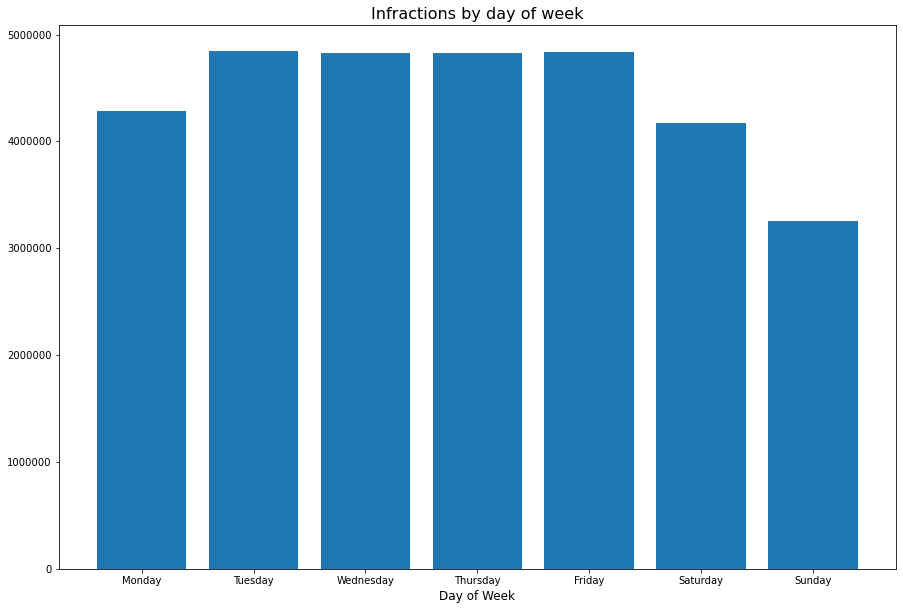

In [389]:
fig, ax=plt.subplots(figsize=(15,10))
plt.title('Infractions by day of week',  fontsize=16)
plt.ticklabel_format(style='plain') 
plt.bar(infractions_weekday['Day of Week'], infractions_weekday['Count'])
plt.xlabel('Day of Week',  fontsize=12)
plt.show()

In [331]:
infractions_weekday.sort_values(by='Count')

,Day of Week,Count,% Change
6,Sunday,3257578,-0.220171
5,Saturday,4177299,-0.135969
0,Monday,4282342,NaN
3,Thursday,4823781,-0.000006
2,Wednesday,4823810,-0.004637
4,Friday,4834664,0.002256
1,Tuesday,4846281,0.131689


In [352]:
infractions_year=(df_Parking_Tickets.groupby(pd.Grouper(key='date_of_infraction', freq='Y')).count()).iloc[:,:1].rename(columns={'date_of_infraction':'Year','tag_number_masked':'Count'})

In [365]:
infractions_year.index=(list(range(2008,2021)))

In [366]:
infractions_year

,Count
2008,2862775
2009,2582382
2010,2721460
2011,2805492
2012,2746154
2013,2613139
2014,2484983
2015,2168493
2016,2254761
2017,2144226


#### We can clearly note that the number of infractions is on steady decline with 2020 having the lowest number of registered infractions

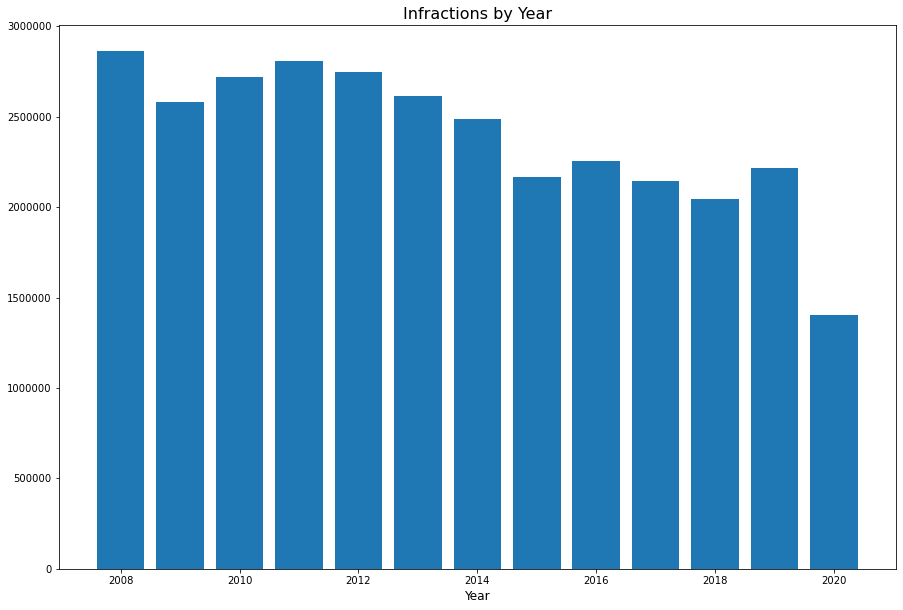

In [390]:
fig, ax=plt.subplots(figsize=(15,10))
plt.title('Infractions by Year',  fontsize=16)
plt.ticklabel_format(style='plain') 
plt.bar(infractions_year.index, infractions_year['Count'])
plt.xlabel('Year',  fontsize=12)
plt.show()

### 6.b.	Month 
#### Impact of month assuming January as a baseline

In [307]:
infractions_month=(df_Parking_Tickets.iloc[:].groupby(df_Parking_Tickets.date_of_infraction.dt.month_name()).count()).iloc[:,:1]

In [308]:
months=[ 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [309]:
infractions_month=infractions_month.reindex(months).reset_index().rename(columns={'date_of_infraction':'Month','tag_number_masked':'Count'})
infractions_month['% Change']=infractions_month.Count.pct_change()
infractions_month

,Month,Count,% Change
0,January,2529272,NaN
1,February,2246202,-0.111918
2,March,2806365,0.249382
3,April,2589512,-0.077272
4,May,2638278,0.018832
5,June,2607581,-0.011635
6,July,2596511,-0.004245
7,August,2629683,0.012776
8,September,2661791,0.012210
9,October,2751265,0.033614


#### We note that most infractions were registered in March followed by October. Least infractions are in February and December.

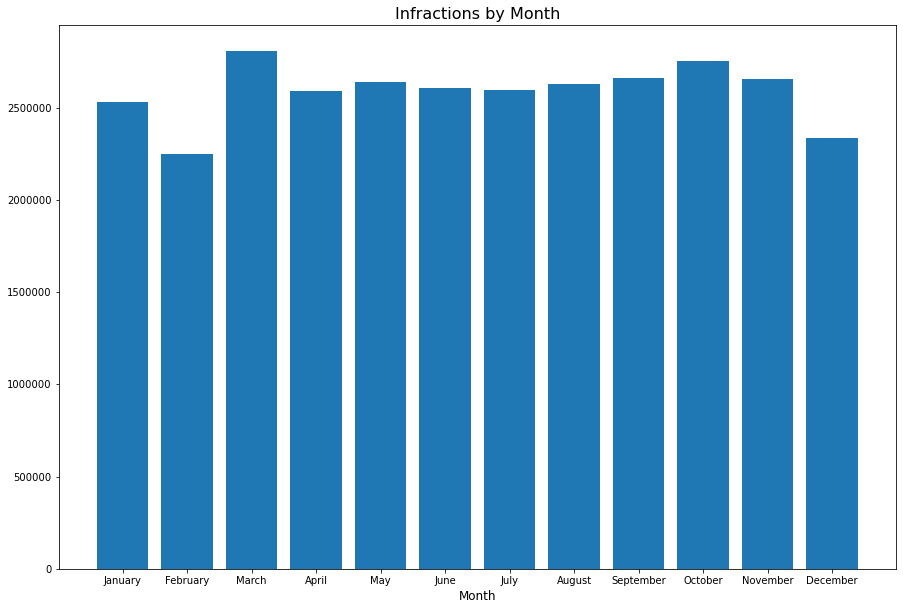

In [391]:
fig, ax=plt.subplots(figsize=(15,10))
plt.title('Infractions by Month',  fontsize=16)
plt.ticklabel_format(style='plain') 
plt.bar(infractions_month.Month, infractions_month['Count'])
plt.xlabel('Month',  fontsize=12)
plt.show()

In [330]:
infractions_month.sort_values(by='Count')

,Month,Count,% Change
1,February,2246202,-0.111918
11,December,2334379,-0.120733
0,January,2529272,NaN
3,April,2589512,-0.077272
6,July,2596511,-0.004245
5,June,2607581,-0.011635
7,August,2629683,0.012776
4,May,2638278,0.018832
10,November,2654916,-0.035020
8,September,2661791,0.012210


### 6.c.	Season
#### Impact of season assuming Fall as a baseline

In [274]:
# For the seasonal distribution we have to create a custom function to determine the season

In [176]:
df_Parking_Tickets['Day_of_year']=df_Parking_Tickets.date_of_infraction.dt.dayofyear

In [225]:
#The four seasons are defined by day of the year. This will be used to assign the season for each date using Timedate library

def assign_season(x):
    
    Winter=(list(range(350,367)))
    Winter.extend((list(range(1,81))))
    Spring=(list(range(81,173)))
    Fall=(list(range(265,350)))
    Summer=list(range(173,265))
    
    if x in Winter:
        return "Winter"
    elif x in Spring:
        return "Spring"
    elif x in Fall:
        return "Fall"
    elif x in Summer:
        return "Summer"
    else:
        return "NA"

In [178]:
df_Parking_Tickets['Season']='Season'

In [243]:
df_Parking_Tickets.Season=df_Parking_Tickets.Day_of_year.apply(assign_season)

In [319]:
Tickets_by_season=(df_Parking_Tickets.groupby(by='Season')).size().reset_index(name='Count')

In [328]:
Tickets_by_season['% Change']=Tickets_by_season.Count.pct_change()

### We can observe no substanial seasonal change, nonetheless infractions took place during Spring, followed by Summer and Winter. Least infractions took place during the Fall.

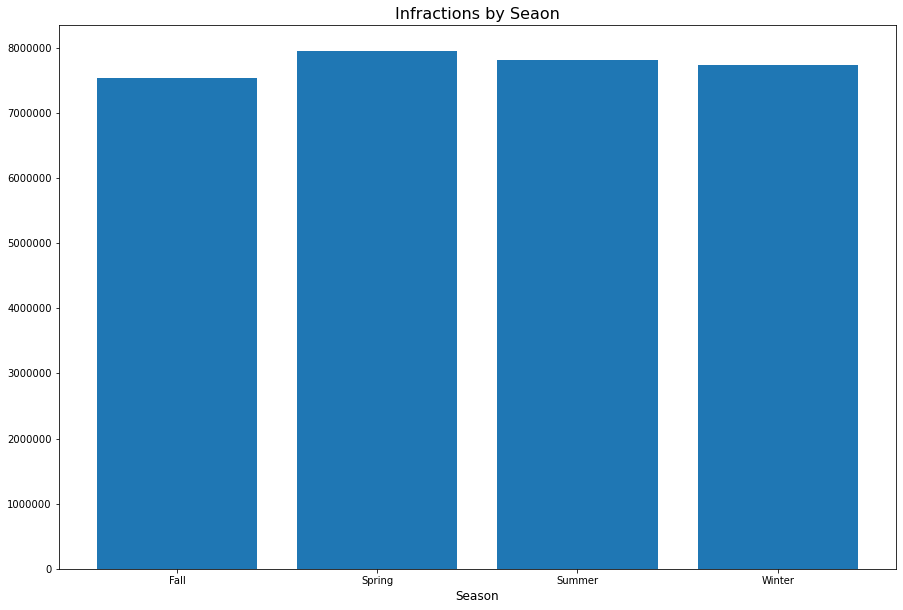

In [393]:
fig, ax=plt.subplots(figsize=(15,10))
plt.title('Infractions by Seaon',  fontsize=16)
plt.ticklabel_format(style='plain') 
plt.bar(Tickets_by_season.Season, Tickets_by_season['Count'])
plt.xlabel('Season',  fontsize=12)
plt.show()

In [329]:
Tickets_by_season

,Season,Count,% Change
0,Fall,7544959,NaN
1,Spring,7950868,0.053799
2,Summer,7819589,-0.016511
3,Winter,7730339,-0.011414
